In [11]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.init import uniform_
import math
from collections import namedtuple, deque
import random
import itertools
import matplotlib.pyplot as plt

In [2]:
# Constants


# Constants
GAMMA = 0.98
BATCH_SIZE = 64
BUFFER_SIZE = 50000

MIN_REPLAY_SIZE = 10000
EPS_START = 0.5
EPS_END = 0.01
EPS_DECAY = 0.995
TARGET_UPDATE_FREQ = 5



# Environment
env = gym.make("LunarLander-v2", render_mode="rgb_array")
obs, _ = env.reset()

# Transition tuple
Transition = namedtuple('Transition', ('states', 'actions', 'rewards', 'dones', 'next_states'))


In [3]:
# Replay Memory class
class ReplayMemory():
    def __init__(self, env, fullsize, minsize, batchsize):
        self.env = env
        self.memory = deque(maxlen=fullsize)
        self.rewards = deque(maxlen=50)
        self.batchsize = batchsize
        self.minsize = minsize

    def append(self, transition):
        self.memory.append(transition)

    def sample_batch(self):
        batch = random.sample(self.memory, self.batchsize)
        batch = Transition(*zip(*batch))
        states = torch.from_numpy(np.array(batch.states, dtype=np.float32))
        actions = torch.from_numpy(np.array(batch.actions, dtype=np.int64)).unsqueeze(1)
        rewards = torch.from_numpy(np.array(batch.rewards, dtype=np.float32)).unsqueeze(1)
        dones = torch.from_numpy(np.array(batch.dones, dtype=np.bool8)).unsqueeze(1)
        next_states = torch.from_numpy(np.array(batch.next_states, dtype=np.float32))
        return states, actions, rewards, dones, next_states

    def initialize(self):
        obs, _ = env.reset()
        for _ in range(self.minsize):
            action = self.env.action_space.sample()
            new_obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            transition = Transition(obs, action, reward, done, new_obs)
            self.append(transition)
            obs = new_obs
            if done:
                self.env.reset()
        return self

In [4]:
# Noisy Linear Layer class
class NoisyLinear(nn.Module):
    def __init__(self, in_size, out_size):
        super(NoisyLinear, self).__init__()

        self.w_mu = nn.Parameter(torch.empty((out_size, in_size)))
        self.w_sigma = nn.Parameter(torch.empty((out_size, in_size)))
        self.b_mu = nn.Parameter(torch.empty((out_size)))
        self.b_sigma = nn.Parameter(torch.empty((out_size)))

        uniform_(self.w_mu, -math.sqrt(3 / in_size), math.sqrt(3 / in_size))
        uniform_(self.b_mu, -math.sqrt(3 / in_size), math.sqrt(3 / in_size))
        nn.init.constant_(self.w_sigma, 0.017)
        nn.init.constant_(self.b_sigma, 0.017)

    def forward(self, x, sigma=0.5):
        if self.training:
            w_noise = torch.normal(0, sigma, size=self.w_mu.size())
            b_noise = torch.normal(0, sigma, size=self.b_mu.size())
            return F.linear(x, self.w_mu + self.w_sigma * w_noise, self.b_mu + self.b_sigma * b_noise)
        else:
            return F.linear(x, self.w_mu, self.b_mu)

In [5]:
# Combined DQN class
class CombinedDQN(nn.Module):
    def __init__(self, ninputs, noutputs):
        super(CombinedDQN, self).__init__()
        self.double_dqn = DQN(ninputs, noutputs)
        self.noisy_dqn = NoisyDQN(ninputs, noutputs)

    def forward(self, X):
        return self.double_dqn(X), self.noisy_dqn(X)

In [6]:
# Double DQN class
class DQN(nn.Module):
    def __init__(self, ninputs, noutputs):
        super(DQN, self).__init__()
        self.a1 = nn.Linear(ninputs, 128)  # Adjust the number of units
        self.a2 = nn.Linear(128, noutputs)

    def forward(self, X):
        o = self.a1(X)
        o = torch.tanh(o)
        o = self.a2(o)
        return o

In [7]:
class NoisyDQN(nn.Module):
    def __init__(self, ninputs, noutputs):
        super(NoisyDQN, self).__init__()
        self.a1 = NoisyLinear(ninputs, 256)
        self.a2 = NoisyLinear(256, 128)  # Experiment with more units
        self.a3 = NoisyLinear(128, noutputs)

    def forward(self, X):
        o = self.a1(X)
        o = torch.relu(o)
        o = self.a2(o)
        o = torch.tanh(o)
        o = self.a3(o)
        return o

In [8]:
def epsilon_greedy_policy(epsilon, obs):
    rnd_sample = random.random()
    if rnd_sample <= epsilon:
        action = env.action_space.sample()
    else:
        with torch.no_grad():
            obs_tensor = torch.from_numpy(obs).float()  # Convert NumPy array to PyTorch tensor
            action = int(torch.argmax(combined_dqn(obs_tensor)[0]))  # Using the double DQN part for action selection
    return action


In [9]:
# Instantiate combined DQN
combined_dqn = CombinedDQN(env.observation_space.shape[0], env.action_space.n)
replay_memory = ReplayMemory(env, BUFFER_SIZE, MIN_REPLAY_SIZE, BATCH_SIZE).initialize()
# Loss function and optimizer
loss_fn = nn.MSELoss()
learning_rate = 0.0005  # Adjust learning rate
optimizer = torch.optim.RMSprop(combined_dqn.parameters(), lr=learning_rate)

obs, _ = env.reset()
eps_threshold = EPS_START
episode = 1
all_rewards = []
all_episodes = []
episode_reward = 0

for step in itertools.count():
    action = epsilon_greedy_policy(eps_threshold, obs)
    new_obs, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    replay_memory.append(Transition(obs, action, reward, done, new_obs))
    episode_reward += reward
    obs = new_obs

    if done:
        episode += 1
        eps_threshold = max(eps_threshold * EPS_DECAY, EPS_END)  # Adjust epsilon decay
        replay_memory.rewards.append(episode_reward)
        obs, _ = env.reset()
        avg_res = np.mean(replay_memory.rewards)

        all_rewards.append(avg_res)
        all_episodes.append(episode)
        if episode % 100 == 0:
            print(f'Episode: {episode} Avg Results: {avg_res} Epsilon: {eps_threshold}')

        if avg_res >= 195:
            print(f'Solved at episode: {episode} Avg Results: {avg_res}')
            break
        episode_reward = 0

    # Sample a batch for training
    b_states, b_actions, b_rewards, b_dones, b_next_states = replay_memory.sample_batch()

    # Update the double DQN part
    qvalues_double_dqn = combined_dqn.double_dqn(b_states).gather(1, b_actions)
    with torch.no_grad():
        _, next_actions_double_dqn = combined_dqn.double_dqn(b_next_states).max(dim=1, keepdim=True)
        next_action_values_double_dqn = combined_dqn.noisy_dqn(b_next_states).gather(1, next_actions_double_dqn)
        expected_qvalues_double_dqn = b_rewards + GAMMA * (1 - b_dones.type(torch.int64)) * next_action_values_double_dqn

    loss_double_dqn = loss_fn(qvalues_double_dqn, expected_qvalues_double_dqn)
    optimizer.zero_grad()
    loss_double_dqn.backward()
    optimizer.step()

    # Update the noisy DQN part
    qvalues_noisy_dqn = combined_dqn.noisy_dqn(b_states).gather(1, b_actions)
    with torch.no_grad():
        target_qvalues_noisy_dqn = combined_dqn.noisy_dqn(b_next_states)
        max_target_qvalues_noisy_dqn = torch.max(target_qvalues_noisy_dqn, axis=1).values.unsqueeze(1)
        expected_qvalues_noisy_dqn = b_rewards + GAMMA * (1 - b_dones.type(torch.int64)) * max_target_qvalues_noisy_dqn

    loss_noisy_dqn = loss_fn(qvalues_noisy_dqn, expected_qvalues_noisy_dqn)
    optimizer.zero_grad()
    loss_noisy_dqn.backward()
    optimizer.step()

    # Inside the training loop after the optimizer.step() for double_dqn
    if episode % TARGET_UPDATE_FREQ == 0:
        # Load the state_dict from double_dqn to noisy_dqn, adapting the keys
        double_dqn_state_dict = combined_dqn.double_dqn.state_dict()
        noisy_dqn_state_dict = combined_dqn.noisy_dqn.state_dict()

        for key in double_dqn_state_dict.keys():
            if key.startswith("double_dqn"):
                # Replace "double_dqn" with "noisy_dqn" in the keys
                noisy_key = key.replace("double_dqn", "noisy_dqn")
                noisy_dqn_state_dict[noisy_key] = double_dqn_state_dict[key]

        # Load the adapted state_dict to noisy_dqn
        combined_dqn.noisy_dqn.load_state_dict(noisy_dqn_state_dict)

C:\Users\Nicholas Vella\anaconda3\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
C:\Users\Nicholas Vella\AppData\Local\Temp\ipykernel_27140\1421935058.py:19: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  dones = torch.from_numpy(np.array(batch.dones, dtype=np.bool8)).unsqueeze(1)


Episode: 100 Avg Results: -115.91552225000241 Epsilon: 0.3044072545179537
Episode: 200 Avg Results: -72.38336114228481 Epsilon: 0.18440091544028497
Episode: 300 Avg Results: 80.83878779431535 Epsilon: 0.11170462303555127
Solved at episode: 384 Avg Results: 198.11491628910696


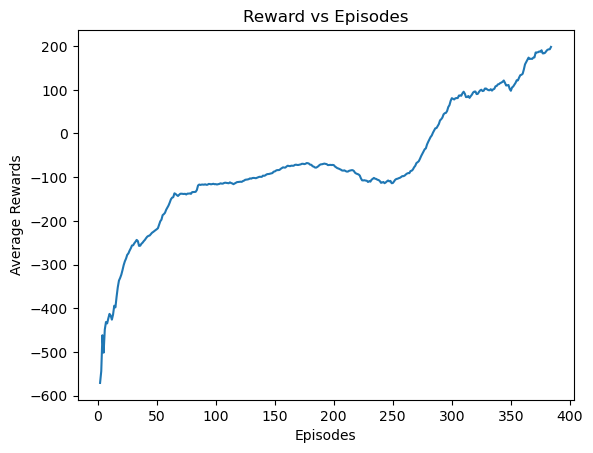

In [12]:
# Plot the returns versus trained episodes
plt.plot(all_episodes, all_rewards)
plt.xlabel('Episodes')
plt.ylabel('Average Rewards')
plt.title('Reward vs Episodes')
plt.show()